# Introduction to Shallow Linear Machine Learning
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

### Normalize Environments
Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/02_01_basic_lda.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/02_01_basic_lda.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [1]:
# Standard block to equalize local and Colab.
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    from google.colab import files
    os.chdir('..')
    if not (Path.cwd() / '.kaggle').is_dir():
        # Configure kaggle
        files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        !pip install -q kaggle
        !mkdir -p ~/.kaggle
        !mv kaggle.json ~/.kaggle/
        !chmod 600 ~/.kaggle/kaggle.json
    if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
        # Download the workshop repo and change to its directory
        # For now edit the username/password. This requirement will be removed when the repo is made public.
        !git clone https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
    IN_COLAB = True
except ModuleNotFoundError:
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')
    IN_COLAB = False

Saving kaggle.json to kaggle.json
Cloning into 'IntracranialNeurophysDL'...
remote: Enumerating objects: 98, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 781 (delta 48), reused 46 (delta 21), pack-reused 683
Receiving objects: 100% (781/781), 23.84 MiB | 26.42 MiB/s, done.
Resolving deltas: 100% (446/446), done.


In [2]:
# Download faces_basic if we don't already have it.
datadir = Path.cwd() / 'data' / 'kjm_ecog'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download -d cboulay/kjm-ecog-faces-basic
    print("Finished downloading. Now extracting contents...")
    data_path = Path('kjm-ecog-faces-basic.zip')
    import zipfile
    with zipfile.ZipFile(data_path, 'r') as zip_ref:
        zip_ref.extractall(datadir / 'converted' / 'faces_basic')
    data_path.unlink()
    print("Finished extracting data.")    

100% 2.24G/2.24G [00:39<00:00, 40.2MB/s]
100% 2.24G/2.24G [00:39<00:00, 61.0MB/s]
Finished downloading. Now extracting contents...
Finished extracting data.


Let's say we have a trivial system of linear equations:

\begin{array}{lcl}
1w_0 + 1w_1 & = & 35\\
2w_0 + 4w_1 & = & 94
\end{array}

This system can be represented in matrix notation, where

$X=\begin{bmatrix}
1 & 2 \\
1 & 4 \\
\end{bmatrix}, 
w=\begin{bmatrix}
w_0 & w_1 \\
\end{bmatrix}, 
y=\begin{bmatrix}
35 & 94 \\
\end{bmatrix}$

$\begin{bmatrix}
w_0 & w_1 \\
\end{bmatrix}
\begin{bmatrix}
1 & 2 \\
1 & 4 \\
\end{bmatrix}
=
\begin{bmatrix}
35 & 94 \\
\end{bmatrix}$

$wX=y$

Let's let w and y be matrices:

$WX=Y$

These variables can take on different meanings depending on the
experiment formulation and type of analysis. This can be confusing.
Instead, let's be consistent about how the variable names map to our data, and then
we will shuffle the equation around as needed.

X: Known brain signals, often reshaped into a matrix.

Y: Known labels (intention, behaviour, experimental conditions).

W: The unknown variable (weights and biases).

| Exp. Type | Equation &nbsp;&nbsp;&nbsp;&nbsp;| X dim | Y | W | 
|---|---|---|---|---| 
|BCI|$WX=Y$|space, time, trials|Intention/Behav.|Decoder|
|Stats|$WY=X$|space, time, trials|Task Cond.|Encoder|
|BCI|$WX=Y$|space, trials|Intention/Behav.|Spatial filter|
|Stats|$WY=X$|space, trials|Task Cond.|Spatial patterns|

---
**Bonus** 

$\begin{array}\\
WX&=&Y \\
W^{-1}WX&=&W^{-1}Y \\
X&=&W^{-1}Y\end{array}$

Or, in other words, the Decoder matrix is the inverse of the Encoder matrix.
See [Haufe et al., NeuroImage 2014](https://www.sciencedirect.com/science/article/pii/S1053811913010914)

---

Let's solve for W

$\begin{array}\\
WX&=&Y \\
WXX^{-1}&=&YX^{-1} \\
W&=&YX^{-1}\end{array}$



In [13]:
import numpy as np

X = np.array([[1, 2,], [1, 4]])
Y = np.array([[35, 94]])
X_inv = np.linalg.inv(X)
W = Y @ X_inv  # or np.matmul(Y, X_inv)
print(W.shape, X.shape, Y.shape)
print("1*{} + 1*{} = 35; {}".format(
    W[0, 0], W[0, 1], 1 * W[0, 0] + 1 * W[0, 1] == 35))
print("2*{} + 4*{} = 94; {}".format(
    W[0, 0], W[0, 1], 2 * W[0, 0] + 4 * W[0, 1] == 94))

(1, 2) (2, 2) (1, 2)
1*23.0 + 1*12.0 = 35; True
2*23.0 + 4*12.0 = 94; True


The majority of brain signal analysis is getting the data into these variables (X, Y),
and then solving this equation, often with different constraints imposed on the solution.

Let's look at one of the most basic examples... 

# (Fisher's) Linear Discriminant Analysis (LDA)

Using the BCI formulation (WX=Y), find the transformation matrix (W) that
maximizes the between-class variance in X relative to the within-class variance in X,
where "class" is encoded in Y.

Note that in the below example, X shape is (trials, features). This requires that X be transposed prior to left-multiplying by W of shape (out_features, in_features). i.e. $Y = WX^T$. The ML library will typically be explicit about whether it wants repetitions (trials) to be in the first dimension or last dimension, and the library will handle transposing and/or right- vs left-multiplying weights as needed.

## Load the data

In [20]:
# Load data from one participant.
SUB_ID = 'de'
from data.utils.fileio import from_neuropype_h5
test_file = datadir / 'converted' / 'faces_basic' / (SUB_ID + '_bp.h5')
chunks = from_neuropype_h5(test_file)
chunk_names = [_[0] for _ in chunks]
chunk = chunks[chunk_names.index('signals')][1]
ax_types = [_['type'] for _ in chunk['axes']]
instance_axis = chunk['axes'][ax_types.index('instance')]
n_trials, n_timepoints, n_channels = chunk['data'].shape
X = chunk['data'].reshape((n_trials, n_timepoints*n_channels))  # 603 trials x 527 features
Y = instance_axis['data']['Marker'].values
print(X.shape, Y.shape)


(603, 527) (603,)


## Plot individual trials

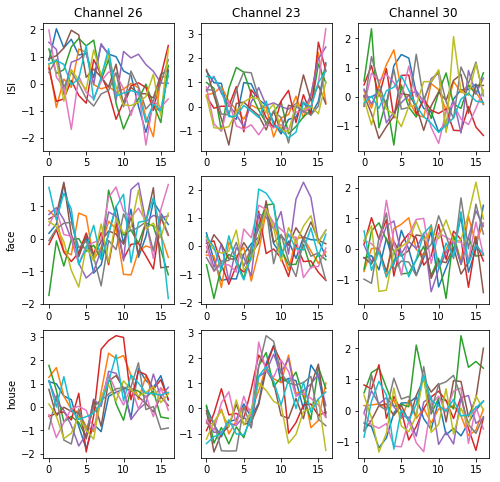

In [58]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 8), facecolor='white')

N_PLOT_CHANS = 3
N_PLOT_TRIALS = 10
uq_Y = np.unique(Y)
plot_chans = np.random.randint(0, n_channels, N_PLOT_CHANS)
for y_ix, y_val in enumerate(uq_Y):
    rand_subset = np.where(Y == y_val)[0]
    np.random.shuffle(rand_subset)
    for ch_ix, chan_id in enumerate(plot_chans):
        plt.subplot(len(uq_Y), len(plot_chans), y_ix * len(plot_chans) + ch_ix + 1)
        plt.plot(chunk['data'][rand_subset[:N_PLOT_TRIALS], :, chan_id].T)
        if ch_ix == 0:
            plt.ylabel(y_val)
        if y_ix == 0:
            plt.title("Channel {}".format(chan_id))
plt.show()


## Plot condition-averaged data

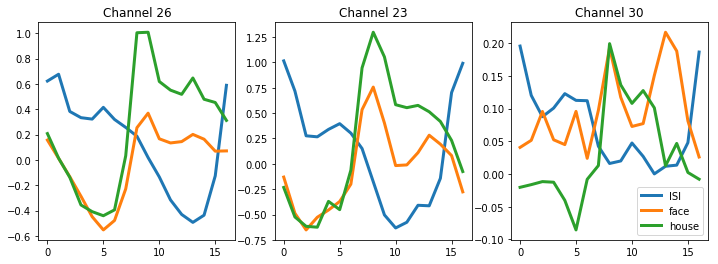

In [63]:
fig = plt.figure(figsize=(12, 4), facecolor='white')
for ch_ix, chan_id in enumerate(plot_chans):
    plt.subplot(1, len(plot_chans), ch_ix + 1)
    for y_ix, y_val in enumerate(uq_Y):
        cond_trials = np.where(Y == y_val)[0]
        _dat = np.mean(chunk['data'][cond_trials, :, chan_id], axis=0)
        plt.plot(_dat, label=y_val, linewidth=3)
    plt.title("Channel {}".format(chan_id))
plt.legend()
plt.show()

## Perform LDA
For a full step-by-step example of doing LDA from scratch, try [this online example](https://www.python-course.eu/linear_discriminant_analysis.php).

Here, let's try to classify these data using simple / shallow machine learning using the excellent scikit-learn Python package.

https://scikit-learn.org/stable/modules/lda_qda.html

Note the LDA initialization argument `shrinkage=auto`. This is a form of regularization. While the exact type of regularization used here is out of scope of the workshop, refer to the sklearn page for more info.
[Link](https://scikit-learn.org/stable/auto_examples/classification/plot_lda.html#sphx-glr-auto-examples-classification-plot-lda-py)

![alt text](https://scikit-learn.org/stable/_images/sphx_glr_plot_lda_001.png)


In [64]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold


lda = LDA(shrinkage='auto', solver='eigen')
splitter = StratifiedKFold(n_splits=10)

y_preds = []
y_true = []
for trn, tst in splitter.split(X, Y):
    lda.fit(X[trn], Y[trn])
    y_preds.append(lda.predict(X[tst]))
    y_true.append(Y[tst])

y_preds = np.hstack(y_preds)
y_true = np.hstack(y_true)

pcnt_corr = 100 * np.sum(y_preds == y_true) / len(y_preds)
print("3-class accuracy: {}".format(pcnt_corr))


3-class accuracy: 97.6782752902156


## Compare accuracy to baseline accuracy
This accuracy seems pretty good, but it's hard to know how good without knowing what
we should expect for baseline accuracy. There are a couple ways to do this.
First, we will shuffle our labels and try again.
Second, we will simply say that every trial is ISI and see how we do.


In [65]:
shuff_preds = []
y_shuff = []
Y_shuff = np.copy(Y)
np.random.shuffle(Y_shuff)
for trn, tst in splitter.split(X, Y_shuff):
    lda.fit(X[trn], Y_shuff[trn])
    shuff_preds.append(lda.predict(X[tst]))
    y_shuff.append(Y[tst])

shuff_preds = np.hstack(shuff_preds)
y_shuff = np.hstack(y_shuff)

pcnt_corr = 100 * np.sum(shuff_preds == y_shuff) / len(y_preds)
print("3-class shuffled accuracy: {}".format(pcnt_corr))

y_always_ISI = np.array(['ISI']*len(y_shuff))
pcnt_corr = 100 * np.sum(y_always_ISI == y_true) / len(y_true)
print("Always-ISI accuracy: {}".format(pcnt_corr))


3-class shuffled accuracy: 41.956882255389715
Always-ISI accuracy: 50.24875621890547


## Confusion Matrix
So the best we can do with random guessing is in the 35-40% range.
The best we can do by guessing always ISI is 50% (note: this is technically "better than chance",
so "better than chance" is meaningless!). This kind of check is very important when the data are not balanced. Imagine a model intended to identify rare diseases; if the model rule was "always False" it might still be 99.99% accurate!

One way to get a good feeling for how your errors are distributed is by plotting a confusion matrix.

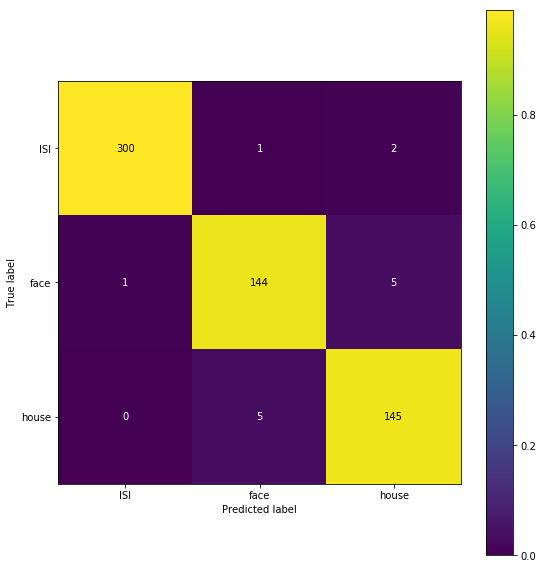

In [67]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt

classes = unique_labels(y_true, y_preds)
cm = confusion_matrix(y_true, y_preds)
cm_int = np.copy(cm)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize
fig, ax = plt.subplots(figsize=(8, 8), facecolor='white')
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
      yticks=np.arange(cm.shape[0]),
      # ... and label them with the respective list entries
      xticklabels=classes, yticklabels=classes,
      ylabel='True label',
      xlabel='Predicted label')

# Loop over data dimensions and create text annotations.
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm_int[i, j], 'd'),
                ha="center", va="center",
                color="black" if cm[i, j] > thresh else "white")
fig.tight_layout()
plt.show()

This is a pretty good result. But remember, we did some significant preprocessing based on years
of expertise working with these types of data.
Also, we used ~540 within-session trials to train the classifier.
This classifier will not generalize well to another patient,
and maybe not even to another session with the same patient.
No one wants to spend 540 trials training a keyboard before they start typing every day.

## Visualize Weights

TODO: Scatterplot per-class weights using electrode locations for x and y.

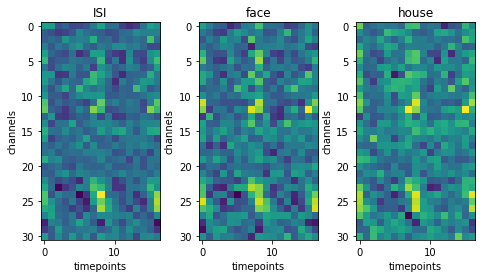

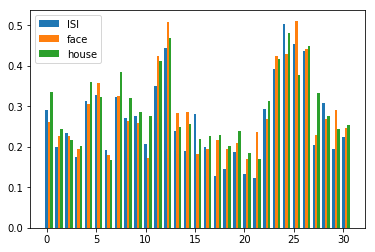

In [84]:
fig = plt.figure(figsize=(8, 4), facecolor='white')
coefs = lda.coef_.reshape(3, n_timepoints, n_channels)
for y_ix, y_val in enumerate(uq_Y):
    plt.subplot(1, 3, y_ix + 1)
    plt.imshow(coefs[y_ix].T)
    plt.title(y_val)
    plt.xlabel('timepoints')
    plt.ylabel('channels')

fig = plt.figure()
width = 0.25
rms_coefs = np.sqrt(np.mean(coefs**2, axis=1))
for y_ix, y_val in enumerate(uq_Y):
    plt.bar(np.arange(n_channels) + y_ix*width, rms_coefs[y_ix], width, label=y_val)
plt.legend()

plt.show()